In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# parallel processing
from multiprocessing import Pool

In [4]:
# samwich routines
from samwich.dataloaders import XarrayData
from samwich.contour_functions import Contours

In [5]:
# case definition
from study import V27, neutral
from trajectory import Trajectory

# Meandering-Frame-of-Reference Analysis
Now, process output from `calculate_wake_MFoR.ipynb`

In [6]:
case = neutral(casedir='WAKEBENCH-NREL_DEBNATH_LES/neutral',
               prefix='NREL_DEBNATH_LES_20190325',
               turbine=V27)

In [7]:
wakedata = {
    '1D Gaussian (Bastankhah)': '1D_Gaussian_Bastankhah',
    '2D Gaussian': '2D_Gaussian',
    'Const area': 'Constant-Area_Contours',
    'Const momentum deficit': 'Constant-Xmom_Contours',
}
suffix = '--filtered'

In [8]:
ds = 0.25
D = case.turbine.D
ymin,ymax = -1.5*D, 1.5*D
zmin,zmax = -1.5*D, 1.5*D # relative to hub height

In [9]:
mean_wake_file = 'mean_wake_mfor.nc'
wake_stdev_file = 'wake_stdev_mfor.nc'

## set up MFoR grid

In [10]:
# points for pcolormesh
y0 = np.arange(ymin,ymax+ds,ds)
z0 = np.arange(zmin,zmax+ds,ds)
yy,zz = np.meshgrid(y0,z0,indexing='ij')

In [11]:
# points passed to `wake.to_MFoR()`
y1 = (y0[1:] + y0[:-1]) / 2
z1 = (z0[1:] + z0[:-1]) / 2
yy,zz = np.meshgrid(y0,z0,indexing='ij')

In [12]:
yy1,zz1 = np.meshgrid(y1,z1,indexing='ij')

## mean MFoR data

In [13]:
edgelevels = -np.array([0.05,0.1,0.3]) * case.Uref
edgelevels

array([-0.435, -0.87 , -2.61 ])

In [14]:
mean_wake = {}
for name,outdir in wakedata.items():
    datafile = os.path.join(case.casedir, outdir+suffix, mean_wake_file)
    mean_wake[name] = xr.open_dataset(datafile) 

In [26]:
displaynames = {
    '1D Gaussian (Bastankhah)': '1D Gaussian\n(Bastankhah model)',
    '2D Gaussian': '2D Gaussian fit',
    'Const area': 'Constant area\ncontours',
    'Const momentum deficit': 'Constant\nx-momentum deficit\ncontours',
}

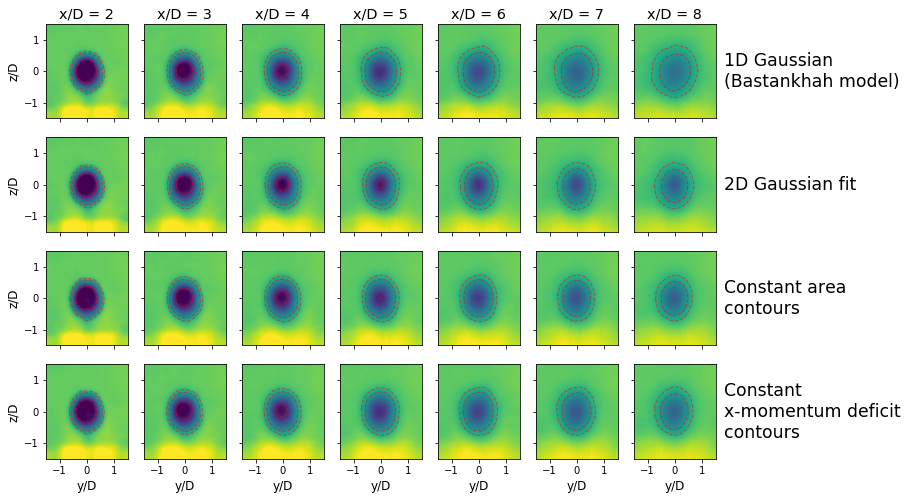

In [32]:
fig,ax = plt.subplots(nrows=len(wakedata.keys()), ncols=len(case.downstreamD),
                      sharex=True, sharey=True,
                      figsize=(12,8))
ymean,zmean = {},{}
max_deficit = {}
for i,name in enumerate(wakedata.keys()):
    vdmax = []
    y,z = [],[]
    for j,downD in enumerate(case.downstreamD):
        planedata = mean_wake[name].sel(x_D=downD).to_array()
        vdmax.append(planedata.min())
        imin,jmin = np.unravel_index(np.argmin(planedata[0,:,:]),yy1.shape)
        y.append(yy1[imin,jmin])
        z.append(zz1[imin,jmin])
        ax[i,j].pcolormesh(yy/D,zz/D,planedata[0,:,:],vmin=-3,vmax=1)
        cont = ax[i,j].contour(yy1/D,zz1/D,planedata[0,:,:],levels=sorted(edgelevels),
                               colors='r',linewidths=1,alpha=0.5)
    max_deficit[name] = np.array(vdmax)
    ymean[name] = np.array(y)
    zmean[name] = np.array(z)
    
# formatting
txt_objs = []
for i,name in enumerate(wakedata.keys()):
    txt = ax[i,-1].text(1.1, 0.5, displaynames[name], fontsize='xx-large',
                        horizontalalignment='left',verticalalignment='center',transform=ax[i,-1].transAxes)
    txt_objs.append(txt)
    ax[i,0].set_ylabel('z/D',fontsize='large')
for j,downD in enumerate(case.downstreamD):
    ax[-1,j].set_xlabel('y/D',fontsize='large')
    ax[0,j].set_title('x/D = {:g}'.format(downD),fontsize='x-large')
    
# save
fig.savefig('figures/all_wakes_MFoR.png',dpi=300,
            bbox_extra_artists=txt_objs, bbox_inches='tight')

In [63]:
selected_downstream = [3,5,7]

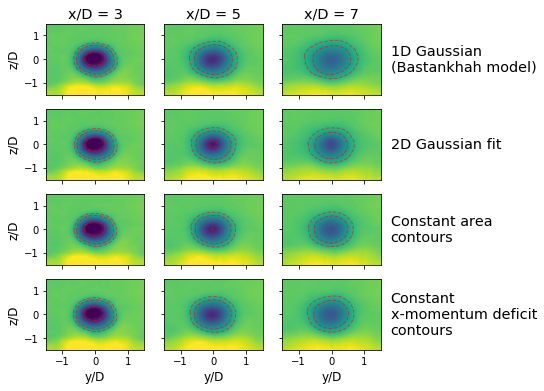

In [67]:
fig,ax = plt.subplots(nrows=len(wakedata.keys()), ncols=len(selected_downstream),
                      sharex=True, sharey=True,
                      figsize=(6,6))
ymean,zmean = {},{}
max_deficit = {}
for i,name in enumerate(wakedata.keys()):
    vdmax = []
    y,z = [],[]
    for j,downD in enumerate(selected_downstream):
        planedata = mean_wake[name].sel(x_D=downD).to_array()
        vdmax.append(planedata.min())
        imin,jmin = np.unravel_index(np.argmin(planedata[0,:,:]),yy1.shape)
        y.append(yy1[imin,jmin])
        z.append(zz1[imin,jmin])
        ax[i,j].pcolormesh(yy/D,zz/D,planedata[0,:,:],vmin=-3,vmax=1)
        cont = ax[i,j].contour(yy1/D,zz1/D,planedata[0,:,:],levels=sorted(edgelevels),
                               colors='r',linewidths=1,alpha=0.5)
    max_deficit[name] = np.array(vdmax)
    ymean[name] = np.array(y)
    zmean[name] = np.array(z)
    
# formatting
txt_objs = []
for i,name in enumerate(wakedata.keys()):
    txt = ax[i,-1].text(1.1, 0.5, displaynames[name], fontsize='x-large',
                        horizontalalignment='left',verticalalignment='center',transform=ax[i,-1].transAxes)
    txt_objs.append(txt)
    ax[i,0].set_ylabel('z/D',fontsize='large')
for j,downD in enumerate(selected_downstream):
    ax[-1,j].set_xlabel('y/D',fontsize='large')
    ax[0,j].set_title('x/D = {:g}'.format(downD),fontsize='x-large')
    
# save
fig.savefig('figures/all_wakes_MFoR_truncated.png',dpi=300,
            bbox_extra_artists=txt_objs, bbox_inches='tight')

### max deficit

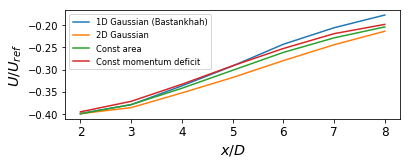

In [49]:
fig,ax = plt.subplots(figsize=(6,2))
for name in wakedata.keys():
    ax.plot(case.downstreamD, max_deficit[name]/case.Uref, label=name)
ax.set_xlabel(r'$x/D$',fontsize='x-large')
ax.set_ylabel(r'$U/U_{ref}$',fontsize='x-large')
ax.tick_params(axis='x',labelsize='large')
ax.legend(fontsize='small')
fig.savefig('figures/wake_VD_MFoR.png',dpi=150,bbox_inches='tight')

In [60]:
recovery = pd.DataFrame(max_deficit,index=case.downstreamD).drop(columns='1D Gaussian (Bastankhah)')
recovery

,2D Gaussian,Const area,Const momentum deficit
2,-3.473266,-3.477240,-3.437804
3,-3.355310,-3.295652,-3.231655
4,-3.066775,-2.975520,-2.897050
5,-2.764984,-2.623576,-2.534811
6,-2.433724,-2.272802,-2.196436
7,-2.122710,-1.987635,-1.905341
8,-1.857702,-1.773146,-1.723387


In [62]:
recovery.max(axis=1) - recovery.min(axis=1)

2    0.039436
3    0.123655
4    0.169724
5    0.230173
6    0.237288
7    0.217369
8    0.134315
dtype: float64

### mean trajectory <font color='red'>?</font>

Text(0.5, 0, '$x/D$')

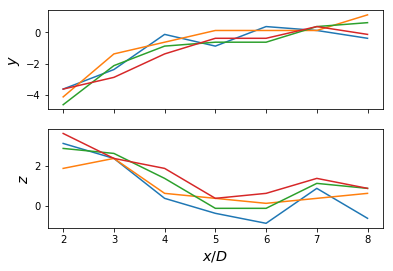

In [17]:
fig,ax = plt.subplots(nrows=2,sharex=True)
for name in wakedata.keys():
    ax[0].plot(case.downstreamD, ymean[name], label=name)
    ax[1].plot(case.downstreamD, zmean[name], label=name)
ax[0].set_ylabel(r'$y$',fontsize='x-large')
ax[1].set_ylabel(r'$z$',fontsize='x-large')
ax[1].set_xlabel(r'$x/D$',fontsize='x-large')


### contour area evolution
from mean wake data

In [18]:
columns = pd.MultiIndex.from_product([wakedata.keys(), edgelevels])
wake_area = pd.DataFrame(index=case.downstreamD,columns=columns)
for name in wakedata.keys():
    areas = np.empty((len(case.downstreamD), len(edgelevels)))
    areas[:,:] = np.nan
    for j,edgelevel in enumerate(edgelevels):
        for i,downD in enumerate(case.downstreamD):
            planedata = mean_wake[name].sel(x_D=downD).to_array()
            cnt = Contours(yy1,zz1,planedata[0,:,:])
            paths = cnt.get_closed_paths(edgelevel)
            if len(paths) > 0:
                assert (len(paths)==1)
                coords = cnt.to_coords(paths[0],array=True)
                areas[i,j] = cnt.calc_area(coords=coords)
            else:
                break
    wake_area[name] = areas

In [19]:
wake_area

1D Gaussian (Bastankhah)                          2D Gaussian              \
                    -0.435      -0.870      -2.610       -0.435      -0.870   
2               965.375000  789.156250  323.906250   970.859375  788.265625   
3              1088.796875  817.812500  215.250000  1066.328125  800.937500   
4              1179.546875  829.406250   99.359375  1116.765625  772.281250   
5              1303.250000  843.000000    7.343750  1145.078125  735.281250   
6              1416.015625  839.484375         NaN  1176.843750  709.437500   
7              1518.437500  801.843750         NaN  1206.500000  639.140625   
8              1607.468750  737.359375         NaN  1206.031250  565.390625   

                Const area                         Const momentum deficit  \
       -2.610       -0.435      -0.870      -2.610                 -0.435   
2  317.296875   950.312500  770.359375  328.234375             982.890625   
3  215.578125  1058.312500  794.546875  219.046875            1090.843750   
4  120.640625  1117.531250  792.828125  113.015625            1169.796875   
5   40.015625  1140.671875  763.781250    3.906250            1203.015625   
6         NaN  1173.859375  731.890625         NaN            1254.406250   
7         NaN  1149.906250  665.546875         NaN            1260.703125   
8         NaN  1124.953125  599.625000         NaN            1227.609375   

                           
       -0.870      -2.610  
2  791.390625  324.921875  
3  821.250000  209.703125  
4  825.203125   89.062500  
5  809.703125         NaN  
6  780.828125         NaN  
7  719.093750         NaN  
8  649.078125         NaN

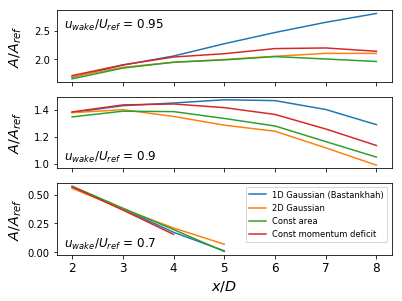

In [45]:
fig,ax = plt.subplots(nrows=len(edgelevels),sharex=True,figsize=(6,4.5))
for name in wakedata.keys():
    for axi,edgelevel in zip(ax,edgelevels):
        axi.plot(case.downstreamD, wake_area[(name,edgelevel)]/case.turbine.rotor_area, label=name)

for axi,edgelevel in zip(ax,edgelevels):
    axi.set_ylabel(r'$A/A_{ref}$',fontsize='x-large')
    vd = (case.Uref + edgelevel)/case.Uref
    displaystr = r'$u_{wake}/U_{ref}$ = ' + '{:g}'.format(vd)
    if axi==ax[0]:
        axi.text(0.02, 0.9, displaystr, fontsize='large',
                 horizontalalignment='left',verticalalignment='top',transform=axi.transAxes)
    else:
        axi.text(0.02, 0.05, displaystr, fontsize='large',
                 horizontalalignment='left',verticalalignment='bottom',transform=axi.transAxes)

fig.align_ylabels()
ax[-1].tick_params(axis='x',labelsize='large')
ax[-1].set_xlabel(r'$x/D$',fontsize='x-large')
ax[-1].legend(loc='best',fontsize='small')

fig.savefig('figures/wake_areas_MFoR.png',dpi=150,bbox_inches='tight')

In [55]:
wake_area.stack().xs(edgelevels[0],level=1) / case.turbine.rotor_area

,1D Gaussian (Bastankhah),2D Gaussian,Const area,Const momentum deficit
2,1.686082,1.695661,1.659774,1.716674
3,1.901645,1.862402,1.848402,1.905220
4,2.060145,1.950494,1.951831,2.043116
5,2.276200,1.999943,1.992248,2.101135
6,2.473151,2.055424,2.050211,2.190891
7,2.652037,2.107220,2.008376,2.201889
8,2.807535,2.106401,1.964794,2.144089


In [54]:
(wake_area.stack().xs(edgelevels[0],level=1) / case.turbine.rotor_area).max()

1D Gaussian (Bastankhah)    2.807535
2D Gaussian                 2.107220
Const area                  2.050211
Const momentum deficit      2.201889
dtype: float64

## stdev MFoR data

In [21]:
wake_stdev = {}
for name,outdir in wakedata.items():
    datafile = os.path.join(case.casedir, outdir+suffix, wake_stdev_file)
    wake_stdev[name] = xr.open_dataset(datafile)

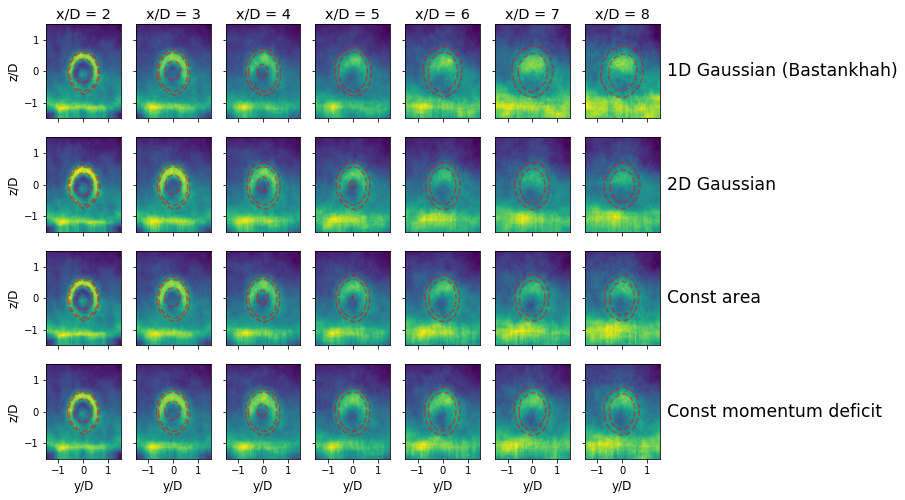

In [22]:
fig,ax = plt.subplots(nrows=len(wakedata.keys()), ncols=len(case.downstreamD),
                      sharex=True, sharey=True,
                      figsize=(11,8))
irow = 0
max_stdev = {}
for name in wakedata.keys():
    stdmax = []
    for i,downD in enumerate(case.downstreamD):
        # plot high turbulence region
        planedata = wake_stdev[name].sel(x_D=downD).to_array()
        stdmax.append(planedata.min())
        ax[irow,i].pcolormesh(yy/D,zz/D,planedata[0,:,:])
        # plot velocity deficit edge from before
        planedata = mean_wake[name].sel(x_D=downD).to_array()
        ax[irow,i].contour(yy1/D,zz1/D,planedata[0,:,:],levels=sorted(edgelevels),colors='r',alpha=0.5)
    max_stdev[name] = np.array(stdmax)
    irow += 1

# formatting
for i,name in enumerate(wakedata.keys()):
    ax[i,-1].text(1.1, 0.5, name, fontsize='xx-large',
                  horizontalalignment='left',verticalalignment='center',transform=ax[i,-1].transAxes)
    ax[i,0].set_ylabel('z/D',fontsize='large')
for j,downD in enumerate(case.downstreamD):
    ax[-1,j].set_xlabel('y/D',fontsize='large')
    ax[0,j].set_title('x/D = {:g}'.format(downD),fontsize='x-large')